# Import Libraries

In [27]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torchsummary import summary

# Preprocessing

## Check CUDA

In [28]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


## Mean and Standard Deviation

In [29]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

loader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)
images, _ = next(iter(loader))
print(images.mean(), images.std())

train_mean = images.mean()
train_std = images.std()

tensor(0.1307) tensor(0.3081)


## Load Data

In [30]:
# Transform: convert to tensor + normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((train_mean,), (train_std,))  # mean and standard deviation as calculated above
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=2000, shuffle=False)


# EDA

## Visualize Data

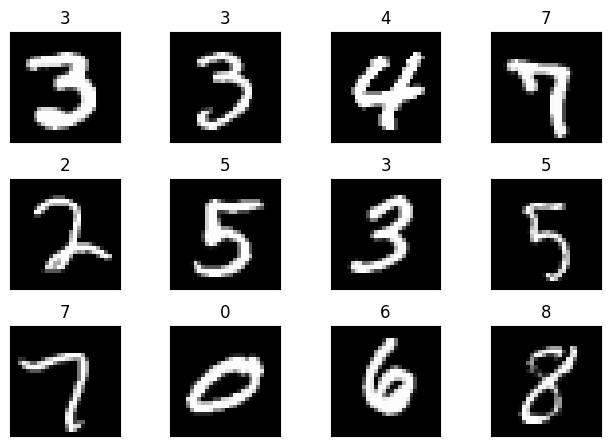

In [31]:
batch_data, batch_label = next(iter(trainloader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

# Actual Modelling

## Approach 1 (Minimize parameters given test accuracy >= 95%)
### Test Accuracy: 95.21% at 2174 trainable parameters

### Model Architecture

In [63]:
class SmallCNN_1(nn.Module):
    def __init__(self):
        super(SmallCNN_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(4, 4, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(4)
        self.fc = nn.Linear(4*7*7, 10)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        x = F.max_pool2d(x, 2, 2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*7*7)
        x = self.fc(x)
        return x

### Training the Model

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN_1().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train for 1 epoch
model.train()
for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

### Train and test accuracy

In [65]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Train Accuracy: {100 * correct / total:.2f}%")

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Train Accuracy: 95.16%
Test Accuracy: 95.21%


### Model Summary

In [66]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
       BatchNorm2d-2            [-1, 4, 28, 28]               8
            Conv2d-3            [-1, 4, 14, 14]             148
       BatchNorm2d-4            [-1, 4, 14, 14]               8
            Linear-5                   [-1, 10]           1,970
Total params: 2,174
Trainable params: 2,174
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.01
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


## Approach 2 (Maximize test accuracy given parameters<25,000)
### Test Accuracy: 98.19% at 24,548 trainable parameters

### Model Architecture

In [74]:
class SmallCNN_2(nn.Module):
    def __init__(self):
        super(SmallCNN_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(32*3*3, 62)
        self.fc2 = nn.Linear(62, 10)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        x = F.max_pool2d(x, 2, 2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
        x = F.max_pool2d(x, 2, 2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 32*3*3)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = self.fc2(x)
        return x

### Model Training

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN_2().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train for 1 epoch
model.train()
for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

### Model Evaluation

In [76]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

train_acc = evaluate(model, trainloader, device)
test_acc = evaluate(model, testloader, device)

print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Train Accuracy: 98.01%
Test Accuracy: 98.19%


### Model Summary

In [77]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 14, 14]           1,168
       BatchNorm2d-4           [-1, 16, 14, 14]              32
            Conv2d-5             [-1, 32, 7, 7]           4,640
       BatchNorm2d-6             [-1, 32, 7, 7]              64
           Dropout-7                  [-1, 288]               0
            Linear-8                   [-1, 62]          17,918
            Linear-9                   [-1, 10]             630
Total params: 24,548
Trainable params: 24,548
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.09
Estimated Total Size (MB): 0.27
---------------------------------------------

# End